In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
y_train_reshaped = y_train.ravel()

x_test_reshaped = x_test.reshape(x_test.shape[0], -1)
y_test_reshaped = y_test.ravel()

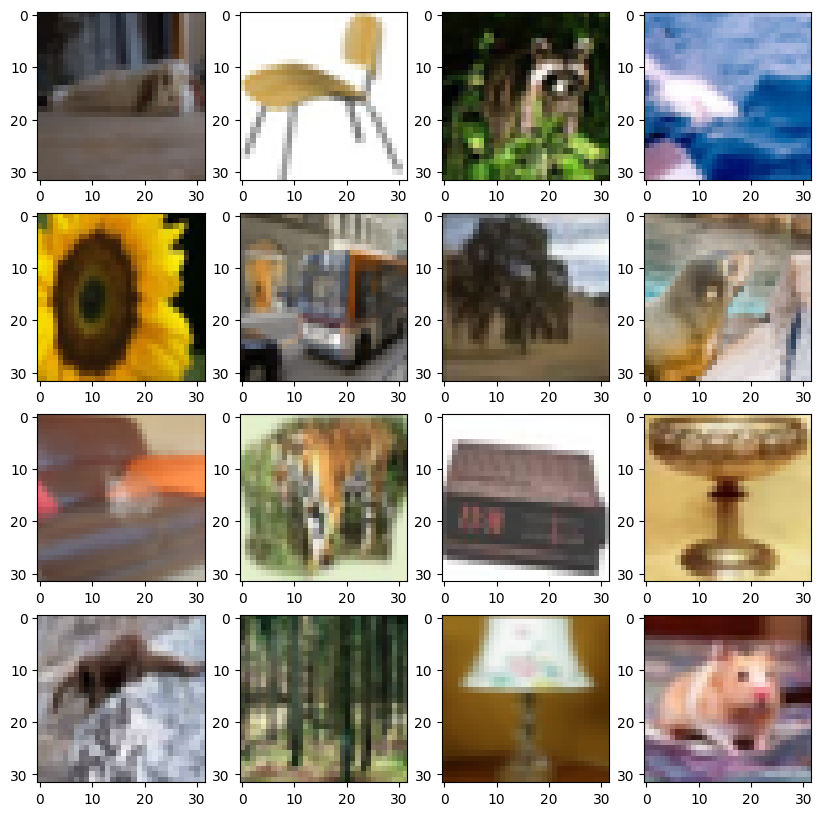

In [7]:
plt.figure(figsize=(10, 10))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(x_train[rand_num])

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

meta_data = unpickle("../usu_zapocet/cifar-100-python/meta")

fine_label_names = np.array([label.decode('utf-8') for label in meta_data[b'fine_label_names']])
coarse_label_names = np.array([label.decode('utf-8') for label in meta_data[b'coarse_label_names']])

print(fine_label_names)
print(coarse_label_names)

['apple' 'aquarium_fish' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle'
 'bicycle' 'bottle' 'bowl' 'boy' 'bridge' 'bus' 'butterfly' 'camel' 'can'
 'castle' 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock' 'cloud'
 'cockroach' 'couch' 'crab' 'crocodile' 'cup' 'dinosaur' 'dolphin'
 'elephant' 'flatfish' 'forest' 'fox' 'girl' 'hamster' 'house' 'kangaroo'
 'keyboard' 'lamp' 'lawn_mower' 'leopard' 'lion' 'lizard' 'lobster' 'man'
 'maple_tree' 'motorcycle' 'mountain' 'mouse' 'mushroom' 'oak_tree'
 'orange' 'orchid' 'otter' 'palm_tree' 'pear' 'pickup_truck' 'pine_tree'
 'plain' 'plate' 'poppy' 'porcupine' 'possum' 'rabbit' 'raccoon' 'ray'
 'road' 'rocket' 'rose' 'sea' 'seal' 'shark' 'shrew' 'skunk' 'skyscraper'
 'snail' 'snake' 'spider' 'squirrel' 'streetcar' 'sunflower'
 'sweet_pepper' 'table' 'tank' 'telephone' 'television' 'tiger' 'tractor'
 'train' 'trout' 'tulip' 'turtle' 'wardrobe' 'whale' 'willow_tree' 'wolf'
 'woman' 'worm']
['aquatic_mammals' 'fish' 'flowers' 'food_containers'
 'frui

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

subset_fraction = 0.3

x_train_subset, _, y_train_subset, _ = train_test_split(
    x_train_reshaped, y_train_reshaped, 
    train_size=subset_fraction, 
    stratify=y_train_reshaped,
    random_state=42
)

pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train_subset)
print(f"Explained variance:  {sum(pca.explained_variance_ratio_)}")

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=3, verbose=3, random_state=42)
random_search.fit(x_train_pca, y_train_subset)

print(f"Best parameters found: {random_search.best_params_}")

Explained variance:  0.9111262520357998
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.296 total time=  51.5s
[CV 2/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.288 total time=  49.5s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.282 total time=  51.6s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=500;, score=0.318 total time= 4.0min
[CV 2/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=500;, score=0.306 total time= 4.3min
[CV 3/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=500;, scor

In [10]:
pca = PCA(n_components=200)
x_train_pca = pca.fit_transform(x_train_reshaped)
x_test_pca = pca.transform(x_test_reshaped)

model = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=40, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
model.fit(x_train_pca, y_train_reshaped)

model.score(x_test_pca, y_test.ravel())

0.3628

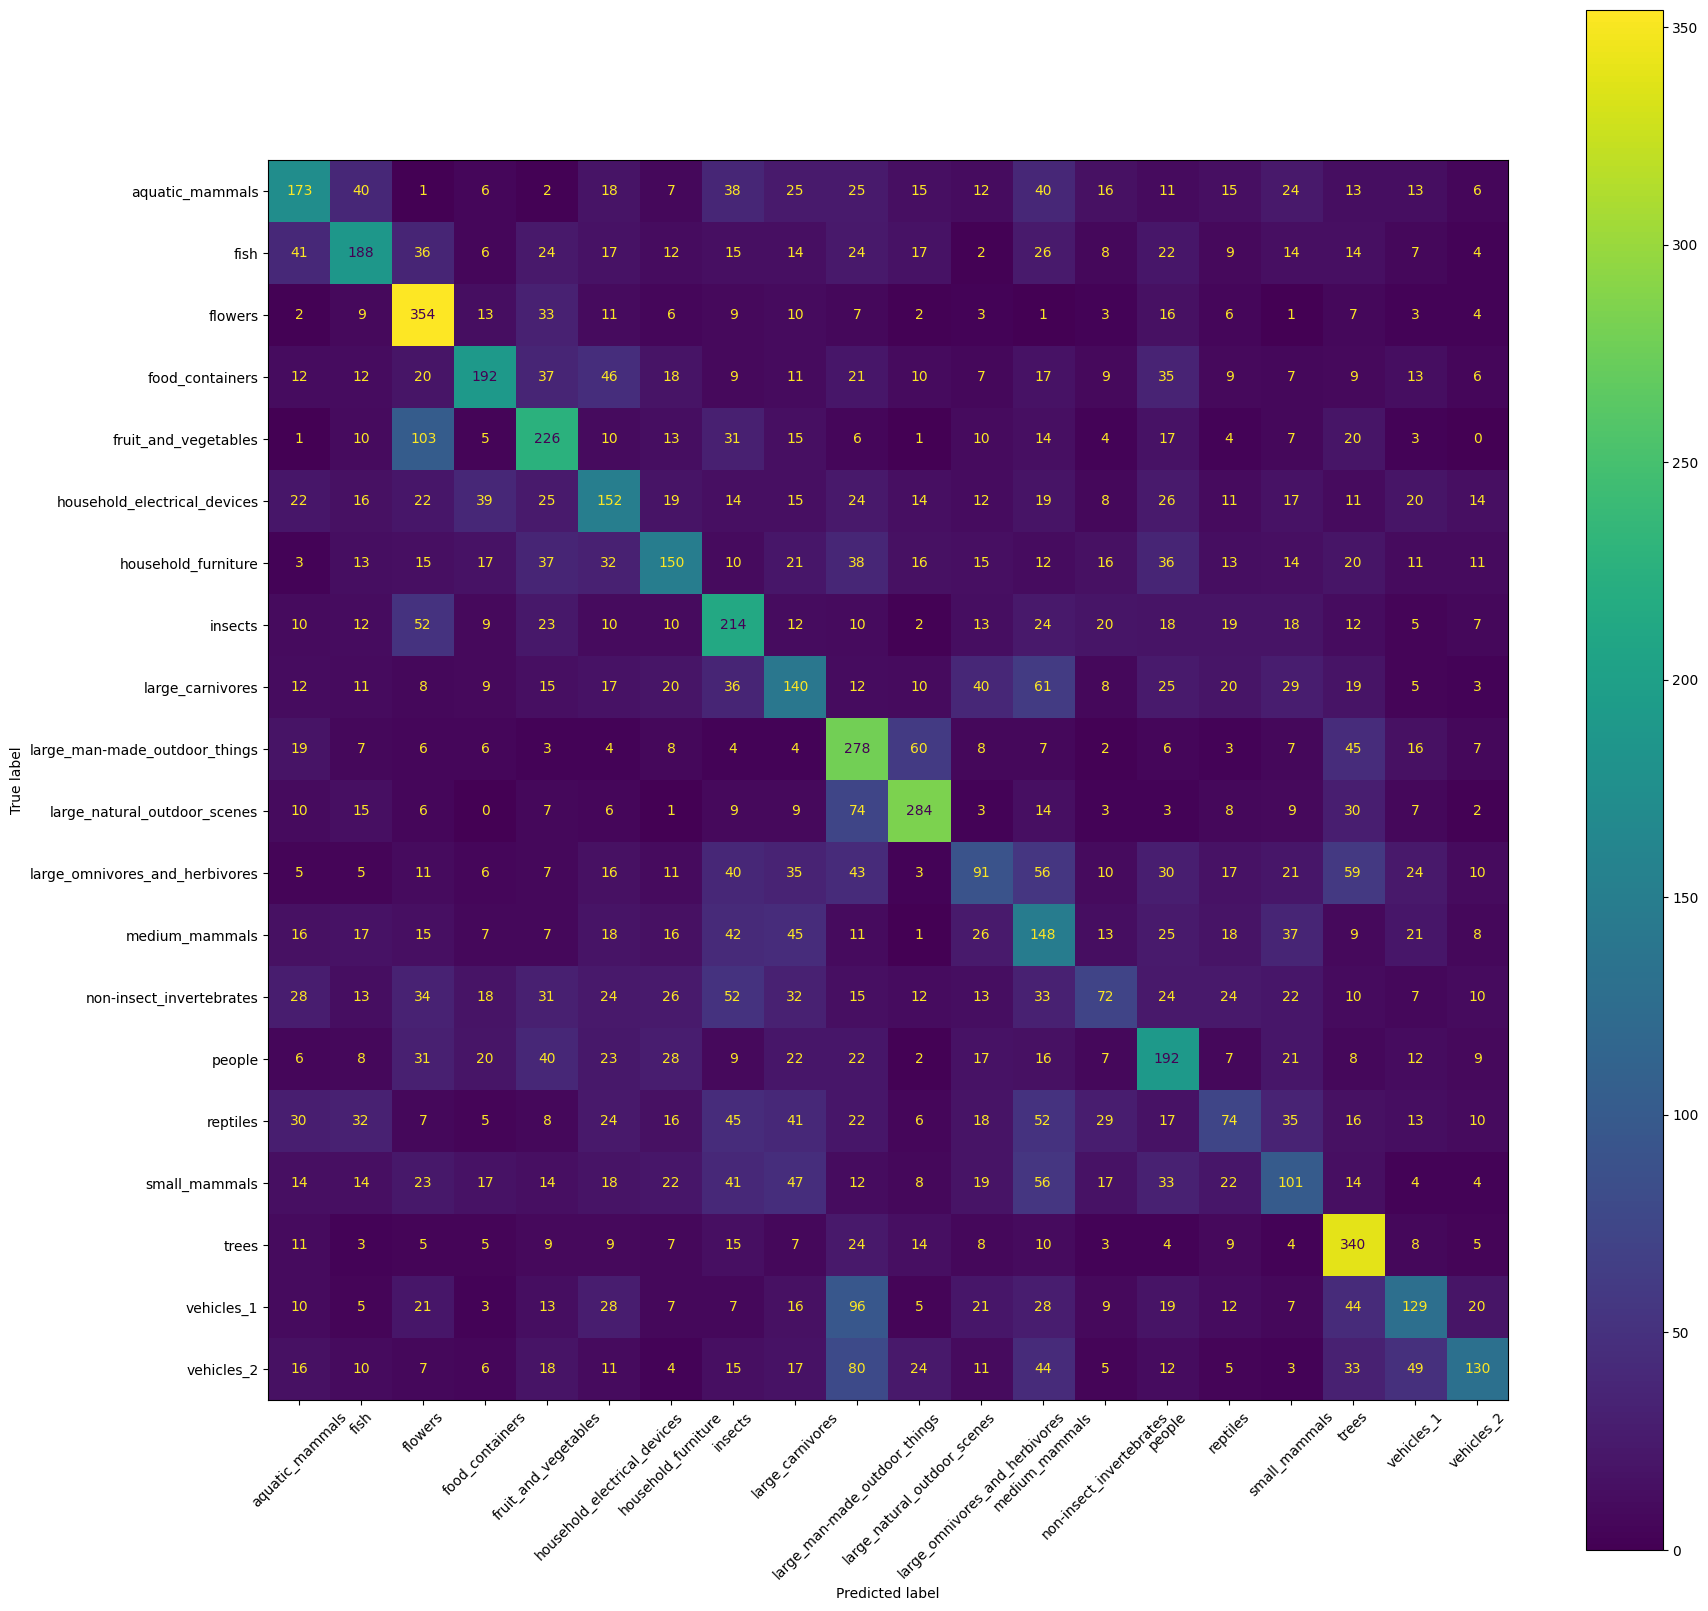

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_hat = model.predict(x_test_pca)

cm = confusion_matrix(y_test_reshaped, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=coarse_label_names)
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax, xticks_rotation=45)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test_reshaped, y_hat, target_names=coarse_label_names))

                                precision    recall  f1-score   support

               aquatic_mammals       0.39      0.35      0.37       500
                          fish       0.43      0.38      0.40       500
                       flowers       0.46      0.71      0.55       500
               food_containers       0.49      0.38      0.43       500
          fruit_and_vegetables       0.39      0.45      0.42       500
  household_electrical_devices       0.31      0.30      0.31       500
           household_furniture       0.37      0.30      0.33       500
                       insects       0.33      0.43      0.37       500
              large_carnivores       0.26      0.28      0.27       500
 large_man-made_outdoor_things       0.33      0.56      0.41       500
  large_natural_outdoor_scenes       0.56      0.57      0.56       500
large_omnivores_and_herbivores       0.26      0.18      0.21       500
                medium_mammals       0.22      0.30      0.25  